CSPB 3202 - HW 5
----------------
Josh White<br/>
jowh8608@colorado.edu<br/>
https://github.com/joshiswhite19/CSPB3202

## Problem Description

The purpose of this model is the identification of metastatic cancer in digital pathology scans, the applications of which have obvious broad utility in cancer screening technology. The data for creating this model is a modified version of the PatchCamelyon (PCam) dataset, which contains several thousand 96x96 pixel RGB color image patches from larger scans. The models will consist of Convolutional Neural Networks developed using the Keras library. Read on to see an exploratory analysis of the data, followed by the creation, training and subsequent testing of said models.

## Library Imports

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import seaborn as sns
import scipy
import scipy.stats
import math
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, datasets, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
with tf.device('/GPU'):
    a = tf.random.normal(shape=(2,), dtype=tf.float32)
    b = tf.nn.relu(a)

Metal device set to: AMD Radeon Pro 560X


2022-08-02 15:08:35.741041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-02 15:08:35.741603: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-02 15:08:35.741909: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Initial Variable Definitions / Assignments

In [3]:
root_dir = os.path.join(os.getcwd(), "Data")
train_files = os.listdir(os.path.join(root_dir, "train"))
train_labels_df = pd.read_csv(os.path.join(root_dir, "train_labels.csv"))
test_files = os.listdir(os.path.join(root_dir, "test"))
test_df = pd.DataFrame(test_files)

## Initial EDA

In [4]:
print(f"Number Training Files: {len(train_files)}")
print(f"Number Training Labels: {len(train_labels_df)}")
print(f"Number Testing Files: {len(test_files)}")

Number Training Files: 220026
Number Training Labels: 220025
Number Testing Files: 57458


In [5]:
train_labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Of the training data, let's see how many are negative for cancer (value 0) and how many are positive (value 1).

In [6]:
(neg, pos) = train_labels_df['label'].value_counts()
print(f"Negative labels: {neg}")
print(f"Positive labels: {pos}")

Negative labels: 130908
Positive labels: 89117


Now that we see how many of each type of image is in the training set, lets see what some of these images actually look like.

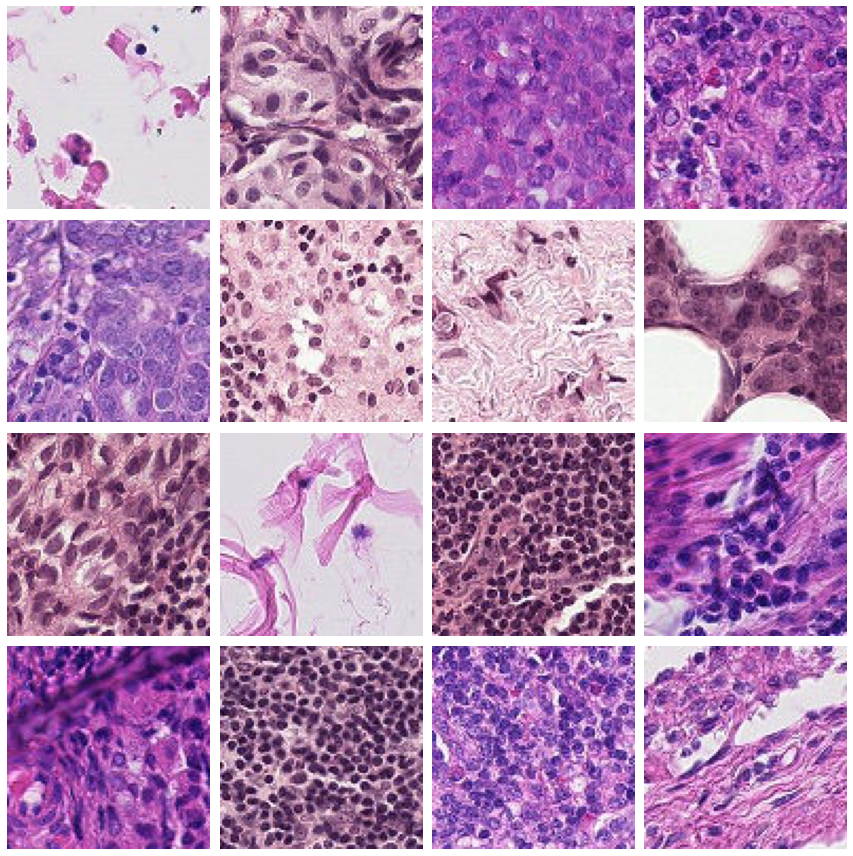

In [7]:
plt.figure(figsize=(12,12))
for index, row in train_labels_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4, 4, index+1)
    plt.imshow(imread(os.path.join(root_dir, f"train/{train_files[index]}")))
    plt.axis('off')
plt.tight_layout()
plt.show()

It is safe to say after looking at this random sample that I have no idea how to identify cancer of my own merits. Hopefully I can train my model to be smarter than me, though! Now that we can see what the images look like, lets look at the shape of a specific image to get a sense of the amount of computation that will be carried out per image.

In [8]:
print(imread(os.path.join(root_dir, f"train/{train_files[0]}")).shape)

(96, 96, 3)


## Import Image Data and Reformat

In order to optimize the flow of such a large amount of data to train and test the model, I will utilize the Keras DataFlowGenerator construct. I discovered this method from [Day Ivy's submission for this competition]( https://www.kaggle.com/code/dayivy/cnn-cancer-detection-kaggle-mini-project).

In [4]:
train_labels_df['id'] = train_labels_df['id']+'.tif'
train_labels_df['label'] = train_labels_df['label'].astype(str)
test_df.columns = ['id']

In [5]:
data_gen = ImageDataGenerator(rescale=1./255, validation_split = .2)

train_gen = data_gen.flow_from_dataframe(
    dataframe   = train_labels_df,
    directory   = os.path.join(root_dir, "train"),
    color_mode  = 'rgb',
    x_col       = "id",
    y_col       = "label",
    subset      = 'training',
    batch_size  = 64,
    seed        = 1234,
    shuffle     = True,
    class_mode  = "binary",
    target_size = (96,96))
valid_gen = data_gen.flow_from_dataframe(
    dataframe   = train_labels_df,
    directory   = os.path.join(root_dir, "train"),
    color_mode  = 'rgb',
    x_col       = "id",
    y_col       = "label",
    subset      = 'validation',
    batch_size  = 64,
    seed        = 1234,
    shuffle     = True,
    class_mode  = "binary",
    target_size = (96,96))

data_gen_test = ImageDataGenerator(rescale=1./255)

test_gen = data_gen_test.flow_from_dataframe(
    dataframe   = test_df,
    directory   = os.path.join(root_dir, "test"),
    color_mode  = 'rgb',
    x_col       = "id",
    batch_size  = 64,
    seed        = 1234,
    shuffle     = False,
    class_mode  = None,
    target_size = (96,96))

train_step_size = train_gen.n//train_gen.batch_size
valid_step_size = valid_gen.n//valid_gen.batch_size

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


## Model Architecture, Creation and Training

Due to the content of the data (96x96 RGB images) and the nature of the binary classification task, this would be a perfect task for a convolutional neural network. From lectures and further independent study, I believe this a network can be built by grouping sets of convolutional layers that are then pooled before being passed to the next set. This method will help refine the features necessary to identify the cancerous images. Finishing off the model with dense layers helps narrow down the features from the convolution layers into the final binary result. There are several hyperparameters that can be tuned in order to refine said model, such as:
- The number of convolutional layers per set
- The number of sets of convolutional layers
- The type of activation function, either ReLU or PReLU
- The optimizer, either RMSprop or Adam
- The number of training epochs

I will play around with all of these features in the following models in an attempt to create a model good enough for the competition.

### Model 1
The first model I will attempt is the same model from the TensorFlow site's [tutorial on CNN](https://www.tensorflow.org/tutorials/images/cnn). It involves three 2D convolution layers that sandwich two max pooling layers, then are flattened and filtered through two dense filters to the model output. It is optimized with RMSprop.

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(96, (3,3), activation='relu', input_shape=(96,96,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(192, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.Flatten())
model.add(layers.Dense(192, activation='relu'))
model.add(layers.Dense(2))
model.summary()
model.compile(optimizer=tf.keras.optimizers.RMSprop(.001),
             loss='binary_crossentropy',
             metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 96)        2688      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 192)       166080    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 192)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 192)       331968    
                                                                 
 flatten (Flatten)           (None, 76800)             0

In [14]:
history = model.fit(
    x                = train_gen,
    steps_per_epoch  = train_step_size,
    validation_data  = valid_gen,
    validation_steps = valid_step_size,
    epochs           = 1,
    verbose          = 1
)

2022-08-01 22:13:38.716212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2750/2750 [==============================] - ETA: 0s - loss: 6.2523 - accuracy: 0.4054

2022-08-01 22:31:34.071712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2750/2750 [==============================] - 1177s 427ms/step - loss: 6.2523 - accuracy: 0.4054 - val_loss: 6.2282 - val_accuracy: 0.4038


That model obviously was no good. Time to pick it up a notch!

### Model 2

This second model is a lot more involved. It involves five separate sets of convolutional layers, followed by five six dense layers to bring it back down to size. The initial convolution is padded to ensure the boundaries are maintained, and the final decision is made on a sigmoid function. This time, I will use the Adam optimizer as well.

In [16]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',input_shape=(96,96,3)))
model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.BatchNormalization())

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.BatchNormalization())

model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.BatchNormalization())

model2.add(layers.Flatten())
model2.add(layers.Dropout(.25))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(.25))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(.25))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(.25))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.summary()
model2.compile(optimizer=tf.keras.optimizers.Adam(.001),
             loss='binary_crossentropy',
             metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 conv2d_19 (Conv2D)          (None, 94, 94, 32)        9248      
                                                                 
 conv2d_20 (Conv2D)          (None, 92, 92, 32)        9248      
                                                                 
 conv2d_21 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 conv2d_22 (Conv2D)          (None, 88, 88, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 44, 44, 32)       0         
 2D)                                                             
                                                      

In [18]:
history2 = model2.fit(
    x                = train_gen,
    steps_per_epoch  = train_step_size,
    validation_data  = valid_gen,
    validation_steps = valid_step_size,
    epochs           = 7,
    verbose          = 1
)

Epoch 1/7
2750/2750 [==============================] - ETA: 0s - loss: 0.4084 - accuracy: 0.8214

2022-08-01 22:53:44.402242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2750/2750 [==============================] - 1163s 423ms/step - loss: 0.4084 - accuracy: 0.8214 - val_loss: 0.6106 - val_accuracy: 0.7013
Epoch 2/7
2750/2750 [==============================] - 1214s 441ms/step - loss: 0.3536 - accuracy: 0.8487 - val_loss: 0.7733 - val_accuracy: 0.6902
Epoch 3/7
2750/2750 [==============================] - 1229s 447ms/step - loss: 0.3135 - accuracy: 0.8685 - val_loss: 0.3590 - val_accuracy: 0.8435
Epoch 4/7
2750/2750 [==============================] - 1171s 426ms/step - loss: 0.2748 - accuracy: 0.8882 - val_loss: 0.2817 - val_accuracy: 0.8874
Epoch 5/7
2750/2750 [==============================] - 1076s 391ms/step - loss: 0.2479 - accuracy: 0.9017 - val_loss: 0.2484 - val_accuracy: 0.8987
Epoch 6/7
2750/2750 [==============================] - 1067s 388ms/step - loss: 0.2316 - accuracy: 0.9090 - val_loss: 0.3390 - val_accuracy: 0.8667
Epoch 7/7
2750/2750 [==============================] - 1067s 388ms/step - loss: 0.2219 - accuracy: 0.9137 - val_loss: 0.24

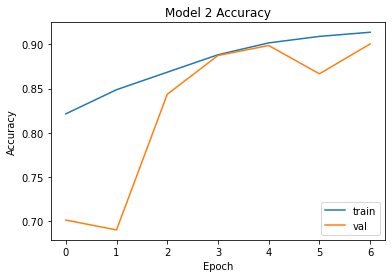

In [33]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

### Model 3

Model 2 did much better than its predecessor. Adding more sets of layers helped, as well as using more epochs. I want to see how much of a difference switching up the convolutional layers and sets makes in the final accuracy with this next model. So I will reduce the number of convolutional layers in each step and increase the total number of steps.

In [14]:
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',input_shape=(96,96,3)))
model3.add(layers.Conv2D(32, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.BatchNormalization())

model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.BatchNormalization())

model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.BatchNormalization())

model3.add(layers.Conv2D(256, (3, 3), activation='relu'))
model3.add(layers.Conv2D(256, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.BatchNormalization())

model3.add(layers.Flatten())
model3.add(layers.Dropout(.25))
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(.25))
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dropout(.25))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(.25))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dropout(.25))
model3.add(layers.Dense(1, activation='sigmoid'))
model3.summary()
model3.compile(optimizer=tf.keras.optimizers.Adam(.001),
             loss='binary_crossentropy',
             metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 conv2d_9 (Conv2D)           (None, 94, 94, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 47, 47, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 43, 43, 64)       

In [15]:
history3 = model3.fit(
    x                = train_gen,
    steps_per_epoch  = train_step_size,
    validation_data  = valid_gen,
    validation_steps = valid_step_size,
    epochs           = 7,
    verbose          = 1
)

Epoch 1/7


2022-08-02 07:58:06.038143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2750/2750 [==============================] - ETA: 0s - loss: 0.3520 - accuracy: 0.8513

2022-08-02 08:06:55.776556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2750/2750 [==============================] - 571s 207ms/step - loss: 0.3520 - accuracy: 0.8513 - val_loss: 0.4438 - val_accuracy: 0.8152
Epoch 2/7
2750/2750 [==============================] - 570s 207ms/step - loss: 0.2472 - accuracy: 0.9026 - val_loss: 0.7452 - val_accuracy: 0.7510
Epoch 3/7
2750/2750 [==============================] - 571s 208ms/step - loss: 0.2088 - accuracy: 0.9203 - val_loss: 0.3012 - val_accuracy: 0.8760
Epoch 4/7
2750/2750 [==============================] - 571s 207ms/step - loss: 0.1853 - accuracy: 0.9306 - val_loss: 0.3537 - val_accuracy: 0.8456
Epoch 5/7
2750/2750 [==============================] - 571s 208ms/step - loss: 0.1687 - accuracy: 0.9372 - val_loss: 0.3129 - val_accuracy: 0.8832
Epoch 6/7
2750/2750 [==============================] - 572s 208ms/step - loss: 0.1539 - accuracy: 0.9433 - val_loss: 1.2166 - val_accuracy: 0.7581
Epoch 7/7
2750/2750 [==============================] - 571s 208ms/step - loss: 0.1394 - accuracy: 0.9485 - val_loss: 1.7862 - va

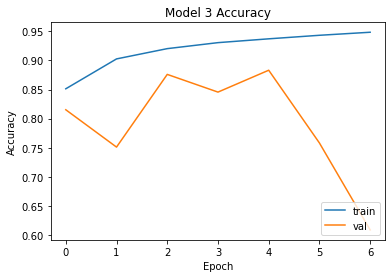

In [16]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model 3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

### Model 4

Now I will attempt to make uses the PReLU activation function instead of the ReLU used in models 2 and 3. I will combine this feature with model 2 and see which performs better.

In [9]:
model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3),
            activation=layers.PReLU(
                alpha_initializer=tf.initializers.Constant(value=0.25)),
             padding='same',input_shape=(96,96,3)))
model4.add(layers.Conv2D(32, (3, 3),
            activation=layers.PReLU(
                alpha_initializer=tf.initializers.Constant(value=0.25))))
model4.add(layers.Conv2D(32, (3, 3),
            activation=layers.PReLU(
                alpha_initializer=tf.initializers.Constant(value=0.25))))
model4.add(layers.Conv2D(32, (3, 3),
             activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model4.add(layers.Conv2D(32, (3, 3),
             activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
model4.add(layers.BatchNormalization())

model4.add(layers.Conv2D(64, (3, 3),
             activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model4.add(layers.Conv2D(64, (3, 3),
             activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model4.add(layers.Conv2D(64, (3, 3),
             activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model4.add(layers.Conv2D(64, (3, 3),
             activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model4.add(layers.Conv2D(64, (3, 3),
             activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
model4.add(layers.BatchNormalization())

model4.add(layers.Conv2D(128, (3, 3),
             activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model4.add(layers.Conv2D(128, (3, 3),
             activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model4.add(layers.Conv2D(128, (3, 3),
             activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model4.add(layers.Conv2D(128, (3, 3),
             activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model4.add(layers.Conv2D(128, (3, 3),
             activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
model4.add(layers.BatchNormalization())

model4.add(layers.Flatten())
model4.add(layers.Dropout(.25))
model4.add(layers.Dense(256, activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model4.add(layers.Dropout(.25))
model4.add(layers.Dense(128, activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model4.add(layers.Dropout(.25))
model4.add(layers.Dense(64, activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model4.add(layers.Dropout(.25))
model4.add(layers.Dense(1, activation='sigmoid'))
model4.summary()
model4.compile(optimizer=tf.keras.optimizers.Adam(.001),
             loss='binary_crossentropy',
             metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 96, 96, 32)        295808    
                                                                 
 conv2d_16 (Conv2D)          (None, 94, 94, 32)        292000    
                                                                 
 conv2d_17 (Conv2D)          (None, 92, 92, 32)        280096    
                                                                 
 conv2d_18 (Conv2D)          (None, 90, 90, 32)        268448    
                                                                 
 conv2d_19 (Conv2D)          (None, 88, 88, 32)        257056    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 44, 44, 32)       0         
 2D)                                                             
                                                      

In [7]:
history4 = model4.fit(
    x                = train_gen,
    steps_per_epoch  = train_step_size,
    validation_data  = valid_gen,
    validation_steps = valid_step_size,
    epochs           = 7,
    verbose          = 1
)

Epoch 1/7


2022-08-02 09:25:30.500237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2750/2750 [==============================] - ETA: 0s - loss: 0.4111 - accuracy: 0.8211

2022-08-02 09:51:06.534182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2750/2750 [==============================] - 1655s 601ms/step - loss: 0.4111 - accuracy: 0.8211 - val_loss: 1.2110 - val_accuracy: 0.6280
Epoch 2/7
2750/2750 [==============================] - 1653s 601ms/step - loss: 0.3358 - accuracy: 0.8589 - val_loss: 0.4318 - val_accuracy: 0.8196
Epoch 3/7
2750/2750 [==============================] - 1649s 600ms/step - loss: 0.2844 - accuracy: 0.8830 - val_loss: 0.2737 - val_accuracy: 0.8910
Epoch 4/7
2750/2750 [==============================] - 1647s 599ms/step - loss: 0.2431 - accuracy: 0.9029 - val_loss: 0.3234 - val_accuracy: 0.8536
Epoch 5/7
2750/2750 [==============================] - 1646s 599ms/step - loss: 0.2095 - accuracy: 0.9187 - val_loss: 0.2958 - val_accuracy: 0.8754
Epoch 6/7
2750/2750 [==============================] - 1647s 599ms/step - loss: 0.1777 - accuracy: 0.9327 - val_loss: 0.2559 - val_accuracy: 0.9031
Epoch 7/7
2750/2750 [==============================] - 1650s 600ms/step - loss: 0.1441 - accuracy: 0.9466 - val_loss: 0.32

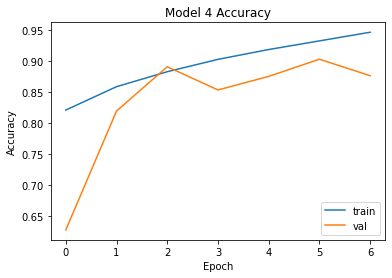

In [8]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model 4 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

### Model 5

It appears that using PReLU with in model 4 improved the final accuracy beyond what was achieved with model 2. Now I will find out if the same is true using model 3 with PReLU.

In [6]:
model5 = models.Sequential()
model5.add(layers.Conv2D(32, (3, 3), activation=layers.PReLU(
                alpha_initializer=tf.initializers.Constant(value=0.25)),
                         padding='same',input_shape=(96,96,3)))
model5.add(layers.Conv2D(32, (3, 3), activation=layers.PReLU(
                alpha_initializer=tf.initializers.Constant(value=0.25))))
model5.add(layers.MaxPooling2D(pool_size=(2, 2)))
model5.add(layers.BatchNormalization())

model5.add(layers.Conv2D(64, (3, 3), activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model5.add(layers.Conv2D(64, (3, 3), activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model5.add(layers.MaxPooling2D(pool_size=(2, 2)))
model5.add(layers.BatchNormalization())

model5.add(layers.Conv2D(128, (3, 3), activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model5.add(layers.Conv2D(128, (3, 3), activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model5.add(layers.MaxPooling2D(pool_size=(2, 2)))
model5.add(layers.BatchNormalization())

model5.add(layers.Conv2D(256, (3, 3), activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model5.add(layers.Conv2D(256, (3, 3), activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model5.add(layers.MaxPooling2D(pool_size=(2, 2)))
model5.add(layers.BatchNormalization())

model5.add(layers.Flatten())
model5.add(layers.Dropout(.25))
model5.add(layers.Dense(512, activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model5.add(layers.Dropout(.25))
model5.add(layers.Dense(256, activation=layers.PReLU(
                alpha_initializer=tf.initializers.Constant(value=0.25))))
model5.add(layers.Dropout(.25))
model5.add(layers.Dense(128, activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model5.add(layers.Dropout(.25))
model5.add(layers.Dense(64, activation=layers.PReLU(
                 alpha_initializer=tf.initializers.Constant(value=0.25))))
model5.add(layers.Dropout(.25))
model5.add(layers.Dense(1, activation='sigmoid'))
model5.summary()
model5.compile(optimizer=tf.keras.optimizers.Adam(.001),
             loss='binary_crossentropy',
             metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        295808    
                                                                 
 conv2d_1 (Conv2D)           (None, 94, 94, 32)        292000    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 47, 47, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        148096    
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 64)        1

In [7]:
history5 = model5.fit(
    x                = train_gen,
    steps_per_epoch  = train_step_size,
    validation_data  = valid_gen,
    validation_steps = valid_step_size,
    epochs           = 7,
    verbose          = 1
)

Epoch 1/7


2022-08-02 15:09:52.198869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2750/2750 [==============================] - ETA: 0s - loss: 0.3730 - accuracy: 0.8432

2022-08-02 15:22:20.042975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2750/2750 [==============================] - 811s 294ms/step - loss: 0.3730 - accuracy: 0.8432 - val_loss: 0.3055 - val_accuracy: 0.8710
Epoch 2/7
2750/2750 [==============================] - 808s 294ms/step - loss: 0.2643 - accuracy: 0.8948 - val_loss: 0.5627 - val_accuracy: 0.7865
Epoch 3/7
2750/2750 [==============================] - 807s 293ms/step - loss: 0.2180 - accuracy: 0.9163 - val_loss: 0.3666 - val_accuracy: 0.8430
Epoch 4/7
2750/2750 [==============================] - 808s 294ms/step - loss: 0.1811 - accuracy: 0.9320 - val_loss: 0.2806 - val_accuracy: 0.8783
Epoch 5/7
2750/2750 [==============================] - 815s 296ms/step - loss: 0.1534 - accuracy: 0.9430 - val_loss: 0.3176 - val_accuracy: 0.8828
Epoch 6/7
2750/2750 [==============================] - 809s 294ms/step - loss: 0.1279 - accuracy: 0.9535 - val_loss: 0.3191 - val_accuracy: 0.8936
Epoch 7/7
2750/2750 [==============================] - 809s 294ms/step - loss: 0.1025 - accuracy: 0.9630 - val_loss: 0.3032 - va

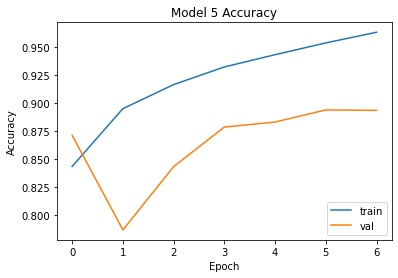

In [8]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Model 5 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Results and Conclusion

After spending several hours training and validating all five model attempts, I can finally produce the following table summarizing and comparing the results:

|   | Model                     | Optimizer | Activation Function | Starting Accuracy | Final Accuracy | Total Epochs | Average Train Time |
|---|---------------------------|-----------|-------------------|-------------------|----------------|--------------|--------------------|
| 1 | TensorFlow Tutorial Model | RMSProp   | ReLU              | 0.4054            | N/A            | 1            | 1177 seconds       |
| 2 | 3 Sets of 5 Conv Layers   | Adam      | ReLU              | 0.8214            | 0.9137         | 7            | 1141 seconds       |
| 3 | 4 Sets of 2 Conv Layers   | Adam      | ReLU              | 0.8513            | 0.9485         | 7            | 571 seconds        |
| 4 | 3 Sets of 5 Conv Layers   | Adam      | PReLU             | 0.8211            | 0.9466         | 7            | 1650 seconds       |
| 5 | 4 Sets of 2 Conv Layers   | Adam      | PReLU             | 0.8432            | 0.9630         | 7            | 810 seconds        |

It appears that model 5, which utilized 4 sets of 5 convolutional layers with the Adam optimizer and PReLU activation function performed the best overall amongst the five models. It took a few minutes longer on average than model 3, so there is a tradeoff on speed vs accuracy which I think may be worth it when dealing with cancer detection.

I think using the PReLU activation function helped the training because it allowed more of the the given nodes to be utilized more efficiently. I also think that there may have been some images in the test data set which I could have trimmed out because they are big outliers that could have thrown off training, which the PReLU activation may have more easily been able to accomodate for. If I had more time, I would have experimented more with switching up the optimizer, but I decided it was better to obeserve the effects of changing activation function instead. 

Lastly, it is clear how much more efficient the models using 4 sets of 2 convolutional layers were than the ones who did a 3-5 layout. This is simple in the numbers, because the 4-2 layout only does 8 sets of computations while the 3-5 does 15, nearly twice as many! There's the added bonus of that model being the most accurate, which I attribute to the fact that the more sets there are, the more features can be exposed, which works well for this sort of detection.

In conclusion, this project has been a lesson in the vast amounts of time required to properly train convolutional neural networks. I also learned that, when architecting a model of this type, the number of epochs involved plays a large role in the final accuracy of the model, in addition to a clean set of data.

## Final Competition Submission

Now that we've made a model that makes decent predictions, let's run it on the actual test data and see how it does in the competition!

In [11]:
test_step_size = test_gen.n/2

predictions = model5.predict(
    x       = test_gen,
    steps   = test_step_size,
    verbose = 1
)

28729/28729 [==============================] - 79s 3ms/step


In [12]:
final_predictions = [1 if pred >= .5 else 0 for pred in predictions]
final_submission = test_df.copy()
final_submission['id'] = final_submission['id'].str[:-4]
final_submission['label'] = final_predictions
final_submission.to_csv('submission.csv', index=False)

For the submission, I received a score of 0.8464. Here is the screenshot of the results from Kaggle:

![Kaggle Competition Results](submission_score.png)

## References
- CNN Cancer Detection Kaggle Mini-Project, Day Ivy, Kaggle, https://www.kaggle.com/code/dayivy/cnn-cancer-detection-kaggle-mini-project/notebook.
- Convolutional Neural Network (CNN), TensorFlow, https://www.tensorflow.org/tutorials/images/cnn.
- Histopathologic Cancer Detection - Image classific, Luiz Martinez, Kaggle, https://www.kaggle.com/code/luizmartinez/histopathologic-cancer-detection-image-classific.